# Music Genre recognition

In [1]:
import music_plots
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import dump, load
import time

from joblib import dump, load

from IPython.core.display_functions import display
from IPython.display import Audio

from livelossplot import PlotLossesKeras
import os

import keras
from keras import layers
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import keras_tuner as kt

from keras_preprocessing.image import img_to_array

import tensorflow as tf
from keras.layers import *

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Introduzione
Classificare i file musicali in base al genere è una sfida del Music Information Retrieval.
In questo progetto si analizzano le prestazioni di diversi modelli di Machine Learning applicati a tale scopo. Dalla letteratura presente in materia, si evince che lo stato dell’arte è rappresentato dall’applicazione di reti neurali convoluzionali alle rappresentazioni visive delle tracce audio (es. spettrogrammi). Questo approccio è paragonato all’applicazione di classificatori tradizionali su feature generate in precedenza dalle tracce audio.

## Dataset
Il dataset utilizzato è quello di Free Music Archive [(Defferrard et al, 2017)](https://arxiv.org/pdf/1612.01840.pdf). Questo fornisce archivi di varie dimensioni:
1. fma_small.zip: 8,000 tracce di 30 secondi, 8 generi bilanciati (7.2 GiB)
2. fma_medium.zip: 25,000 tracce di 30 secondi, 16 generi non bilanciati (22 GiB)
3. fma_large.zip: 106,574 tracce di 30 secondi, 161 generi non bilanciati (93 GiB)
4. fma_full.zip: 106,574 tracce non tagliate, 161 generi non bilanciati (879 GiB)
Inoltre sono presenti dei file come tracks.csv, features.csv e echonest.csv, che contengono dati riguardanti tracce, album e artisti. Per limitare lo spazio occupato su disco e i tempi di esecuzione è stato utilizzato solamente il dataset small.

### Generi
Come visto in precedenza, i dataset più piccoli non contengono tutti i generi e i sottogeneri. I modelli allenati su questi non saranno quindi in grado di riconoscere i generi mancanti.
Non è sempre possibile conferire un’attribuzione oggettiva ai generi musicali. Ad esempio, la definizione di una canzone come parte del genere "international" è altamente correlata al contesto dell’utente. Alcune canzoni, inoltre, possono subire l’influenza di più generi. La mancanza di valutazioni oggettive e la difficile separazione tra le classi rendono il problema della classificazione dei generi particolarmente impegnativo.

## Preprocessing
I file audio sono convertiti da mp3 a wav sfruttando la libreria Python pydub, la quale si serve internamente di ffmpeg. I file che causano eccezioni durante la conversione, ad esempio perché sono di durata nulla, sono scartati dal dataset.

## Metodologia

### Utilizzando dataset di FMA

Basandosi sull’esempio fornito da FMA in features.csv, sono state generate diverse feature a partire dalle tracce audio usando librosa. Non sono state utilizzate le caratteristiche fornite da echonest poiché l’API non è più disponibile e i dati presenti in echonest.csv sono pochi. Sono calcolate media, deviazione standard, skewness, kurtosis, mediana, minimo e massimo delle seguenti feature:

- Chroma: Un file audio può consistere di 12 differenti classi di altezze (pitch class). Queste corrispondono a tutte le note distanti un numero intero di ottave (es. tutte le note DO ad una distanza di una o più ottave). I chromagrammi rappresentano l’intensità delle classi di altezze di una file audio nel tempo.
  - chroma_stft (standard chromagram, 12 sample): cromagramma che viene calcolato dallo spettrogramma dei file audio.
  - chroma_cens(Computes the chroma variant “Chroma Energy Normalized Statistics” (CENS), 12 sample): Il cromagramma è costituito da segnali in forma di energia. L'idea principale delle caratteristiche CENS è che l'analisi statistica su ampie finestre attenua le deviazioni locali del tempo, dell'articolazione e degli ornamenti musicali, come trilli e accordi arpeggiati.
  - chroma_cqt (Constant-Q chromagram, 12 sample): cromagramma del segnale con trasformata Constant-Q. Questa trasformazione del segnale avviene dal dominio del tempo al dominio della frequenza ed è correlata alla trasformata di Fourier e alla trasformata wavelet di Morlet. La Constant-Q Transform (CQT) fa sì che le frequenze centrali dei bin di frequenza siano geometricamente distanziate e i loro fattori Q siano tutti uguali. Il fattore Q è definito come il rapporto tra l'energia iniziale immagazzinata nel risonatore e l'energia persa in un radiante del ciclo di oscillazione.

- mfcc (20 sample): Mel-frequency cepstral coefficients (MFCCs) sono coefficienti che compongono collettivamente un MFC(mel-frequency cepstrum). MFC è una rappresentazione dello spettro di potenza a breve termine di un suono, basato su una trasformata coseno lineare di uno spettro di potenza log su una scala mel non lineare di frequenza.
- rmse (1 sample): La root-mean-square è utilizzata per caratterizzare un'onda sonora perché è direttamente correlata all'energia trasportata dall'onda sonora, che è chiamata intensità. L'intensità di un'onda sonora è la quantità media di energia trasmessa per unità di tempo attraverso un'area unitaria in una direzione specifica.

- spectral_bandwidth (1 sample): La larghezza di banda è la differenza tra le frequenze superiori e inferiori in una banda continua di frequenze.
- spectral_centroid (1 sample): Il centroide spettrale è la posizione del centro di massa dello spettro.
- spectral_rolloff (1 sample):Lo spectral roll-off è la frequenza sotto la quale si trova una data percentuale dell’energia totale dello spettro (nel nostro caso 85%)

- zcr (1 sample): Zero-crossing è la misura della velocità con cui il segnale passa da positivo a negativo o viceversa.
- spectral_contrast (7 sample): In un segnale audio, il contrasto spettrale è la misura dell'energia della frequenza ad ogni timestamp.
- tonnetz (6 sample): Il tonnetz è ottenuto dalla proiezione delle chroma features da 12 a 6 dimensioni. In questa nuova base gli intervalli di quinta, terza minore, terza maggiore sono rappresentati come coordinate a due dimensioni

### Utilizzando spettrogrammi

Diversi metodi presentati nei paper analizzati. Molti si basano su spettrogrammi. In particolare si utilizzano i mel-spectrogram. Questi sono un degli spettrogrammi con frequenze convertite nella scala mel.

Come detto precedentemente, gli esempi più accurati presenti in letteratura si basano sull’analisi degli spettrogrammi delle tracce audio. In particolare, si utilizzano i mel-spectrogram, i quali utilizzano frequenze convertite nella scala mel.
Questo viene fatto perché studi hanno dimostrato che l'orecchio umano non riesce a percepire le frequenze nello stesso modo. Per esempio siamo in grado di percepire la differenza tra 500Hz e 1000Hz, ma risulta essere più difficile percepire la differenza tra 10,000Hz e 10,500Hz, anche se la distanza è la stessa.
Nel 1937, Stevens, Volkmann e Newmann proposero un'unità di intonazione tale che distanze uguali in frequenza sembrassero ugualmente distanti per l'ascoltatore. Questa è chiamata scala mel.


<div>
<img src="mel_scale.png" width="500"/>
</div>


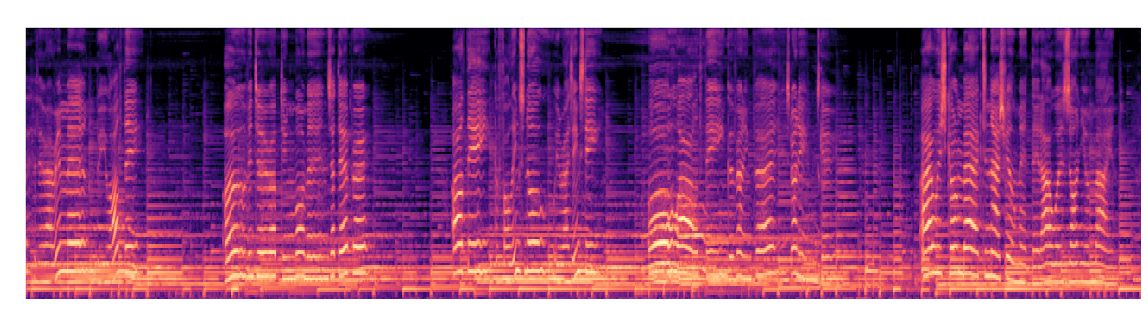

In [15]:
music_plots.plot_mel_spectrogram('data/tracks_wav/127266.wav')

Vengono inoltre utilizzati in alcuni paper i chroma spectrogram, che sono degli spettrogrammi in cui si vede la potenza delle varie note durante per il tempo.

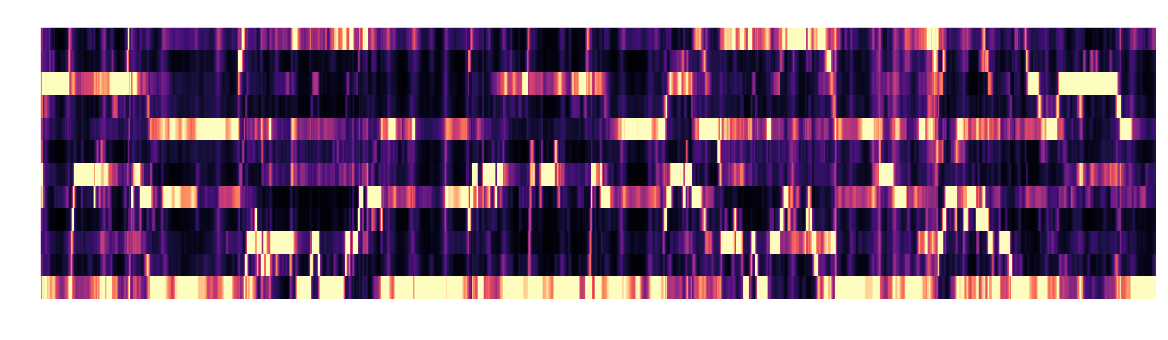

In [14]:
music_plots.plot_chroma('data/tracks_wav/127266.wav')

# Classificatori utilizzati

- Basati sulle feature
    - SVM
    - Random Forest
    - Naive Bayes
- Basati sugli spettrogrammi
    - Modello spettrogrammi
    - Modello Chroma
    - Multi-input model spettrogrammi, Chroma
    - Transfer learning con VGG16 per spettrogrammi

PCA?

I modelli sono stati ottimizzati utilizzando keras-tuner.

# Preparazione dei dati

## Dati Classificatori

In [2]:
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

features_df = pd.read_csv('new_features.csv', index_col=0, header=[0, 1, 2])

display(tracks_df)
display(genres_df)
display(features_df)

album                                                              \
         comments        date_created date_released engineer favorites     id   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4      6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2      4   
...           ...                 ...           ...      ...       ...    ...   
155316          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155317          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155318          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155319          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155320          0 2017-03-26 16:22:18    2017-03-26      NaN         1  22906   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
3                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
20                <p> "spiritual songs" from Nicky Cook</p>    2710   
...                                                     ...     ...   
155316    <p>A live performance at Monty Hall on Feb 17,...    1506   
155317    <p>A live performance at Monty Hall on Feb 17,...    1506   
155318    <p>A live performance at Monty Hall on Feb 17,...    1506   
155319    <p>A live performance at Monty Hall on Feb 17,...    1506   
155320                                                  NaN    7481   

                                                                          ...  \
             producer                                               tags  ...   
track_id                                                                  ...   
2                 NaN                                                 []  ...   
3                 NaN                                                 []  ...   
5                 NaN                                                 []  ...   
10                NaN                                                 []  ...   
20                NaN                                                 []  ...   
...               ...                                                ...  ...   
155316    Monty Hall                                                  []  ...   
155317    Monty Hall                                                  []  ...   
155318    Monty Hall                                                  []  ...   
155319    Monty Hall                                                  []  ...   
155320            NaN  [ballad, epic, rockabilly, curse, hex, hard ro...  ...   

               track                         \
         information interest language_code   
track_id                                      
2                NaN     4656            en   
3                NaN     1470            en   
5                NaN     1933            en   
10               NaN    54881            en   
20               NaN      978            en   
...              ...      ...           ...   
155316           NaN      122           NaN   
155317           NaN      194           NaN   
155318           NaN      214           NaN   
155319           NaN      336           NaN   
155320           NaN      972           NaN   

                                                                              \
        

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
6608         -0.514136  0.102025  3.211623 -0.409699  2.310633 -0.624384   
98550        -0.888496 -0.543275 -0.268409  2.081209 -0.176785 -0.039511   
98236         7.571894  0.799434  0.338393 -0.840908 -0.586132  0.280276   
147126       -0.953074 -0.437103 -0.010938 -1.316950 -0.836699  1.241229   
4779         -0.866279 -0.287412 -0.647487  0.316349 -0.000807  0.165982   
...                ...       ...       ...       ...       ...       ...   
119725       -0.281480 -0.637733  0.593827 -0.005050 -0.721143 -0.232277   
98549        -0.710265 -0.405176 -0.252436 -0.445528 -0.263628 -0.032077   
131917       -0.543134 -0.008171 -0.314506 -0.880054  0.129443 -1.029797   
6611         -0.777327 -0.837879  0.140058 -0.289560 -0.713159  0.290365   
51991        -0.263679 -0.394670 -0.364069 -0.696705 -1.144195 -0.838824   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
6608       -0.490104 -0.467654 -0.326958 -0.707326  ...  0.134904  0.041301   
98550       1.264057  2.085742 -0.238240 -0.797922  ...  0.128017  0.040760   
98236      -0.735879 -0.386995 -0.195639 -1.112090  ...  0.067507  0.026138   
147126      2.933952  0.486668  1.840397  4.451793  ...  0.206924  0.080330   
4779       -0.396568 -0.555789  0.213659 -0.419588  ...  0.139869  0.039593   
...              ...       ...       ...       ...  ...       ...       ...   
119725     -0.340328  0.610787  1.124747  0.084618  ...  0.100658  0.031662   
98549       0.442745  0.342770  3.655493  1.776285  ...  0.144739  0.038135   
131917     -0.325549 -0.341389 -0.299172 -1.079364  ...  0.203034  0.069247   
6611        0.386784 -0.347761  2.499937  0.757803  ...  0.106074  0.039008   
51991      -0.786097  2.458862  2.432818 -0.969633  ...  0.231761  0.052110   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
6608        0.055328  10.324201  0.373535  0.065738  0.056152  0.007812   
98550       0.052715   0.809276  0.449219  0.151485  0.141602  0.010742   
98236       0.021610  -0.197926  0.029297  0.015841  0.015625  0.005859   
147126      0.094053   8.920524  0.119141  0.016191  0.013672  0.001953   
4779        0.042502   2.248410  0.201660  0.058082  0.056152  0.010254   
...              ...        ...       ...       ...       ...       ...   
119725      0.043944  18.474745  0.272461  0.045331  0.043457  0.002930   
98549       0.045694   0.159378  0.323730  0.119189  0.110352  0.002441   
131917      0.066808   0.087486  0.053223  0.024084  0.022949  0.008789   
6611        0.046695   8.874200  0.288574  0.061133  0.053711  0.006348   
51991       0.046990   1.405643  0.314941  0.073302  0.056152  0.003906   

feature                         
statistics      skew       std  
number            01        01  
6608        2.651123  0.043814  
98550       0.968062  0.078302  
98236       0.254955  0.003936  
147126      2.413915  0.012465  
4779        0.999470  0.022155  
...              ...       ...  
119725      3.457297  0.031024  
98549       0.542414  0.053406  
131917      0.711797  0.007247  
6611        2.445617  0.035670  
51991       1.385214  0.060200  

[7847 rows x 518 columns]

Si cercano eventuali righe con valori NaN. Quelle trovate derivano da problemi della libreria librosa.

In [3]:
features_df[features_df.isna().any(axis=1)]

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
132567        8.886270 -1.414148 -0.863564 -1.491122  5.415106  1.714882   
38880        -0.543963  0.140875 -0.058026  0.714167  0.166571 -0.275367   
105719       -0.923114 -0.815079 -0.571728 -0.433651 -0.369833  1.145267   
98567              NaN       NaN       NaN       NaN       NaN       NaN   
107535             NaN       NaN       NaN       NaN       NaN       NaN   
69002         0.585960  0.261052  0.284908 -0.021662 -0.206454 -0.044749   

feature                                               ...   tonnetz            \
statistics                                            ...       std             
number            07        08         09         10  ...        04        05   
132567      4.799457  1.320694  -0.877420  -0.697034  ...  0.150592  0.083992   
38880       0.078154 -0.054806  -0.478200   1.870654  ...  0.057027  0.023077   
105719     -0.877119 -1.176432  -0.680055   0.907306  ...  0.081169  0.031749   
98567            NaN       NaN        NaN        NaN  ...       NaN       NaN   
107535           NaN       NaN        NaN        NaN  ...       NaN       NaN   
69002      -0.441261  6.662327  19.752533  53.921280  ...  0.075644  0.026490   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
132567      0.146248   9.529501  0.019043  0.003209  0.002930  0.000977   
38880       0.022789   4.557822  0.043457  0.007097  0.005859  0.000488   
105719      0.043327   2.536167  0.018555  0.003385  0.002930  0.000000   
98567            NaN   2.209920  0.041992  0.036066  0.037354  0.019043   
107535           NaN  22.027853  0.002930  0.000067  0.000000  0.000000   
69002       0.032230   9.105909  0.058105  0.005238  0.003418  0.000000   

feature                         
statistics      skew       std  
number            01        01  
132567      2.166500  0.001608  
38880       1.724214  0.005626  
105719      1.218001  0.002510  
98567      -1.339104  0.004693  
107535      4.285109  0.000262  
69002       2.453628  0.005928  

[6 rows x 518 columns]

Si vanno a prendere le tracce presenti nel dataset features_df e si eliminano le righe con valori NaN. Viene generato il dataset track_genres che contiene i generi assegnati alle tracce.

In [6]:
track_genres = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[features_df.dropna().index]
track_genres = track_genres.dropna()
features_df = features_df.loc[track_genres.index]

track_genres

6608            Hip-Hop
98550           Hip-Hop
98236      Instrumental
147126     Instrumental
4779               Rock
              ...      
119725             Folk
98549           Hip-Hop
131917     Instrumental
6611            Hip-Hop
51991     International
Name: genre_top, Length: 7841, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Rock             991
Electronic       990
Experimental     987
International    986
Instrumental     982
Folk             976
Hip-Hop          974
Pop              955
Name: genre_top, dtype: int64


<AxesSubplot:>

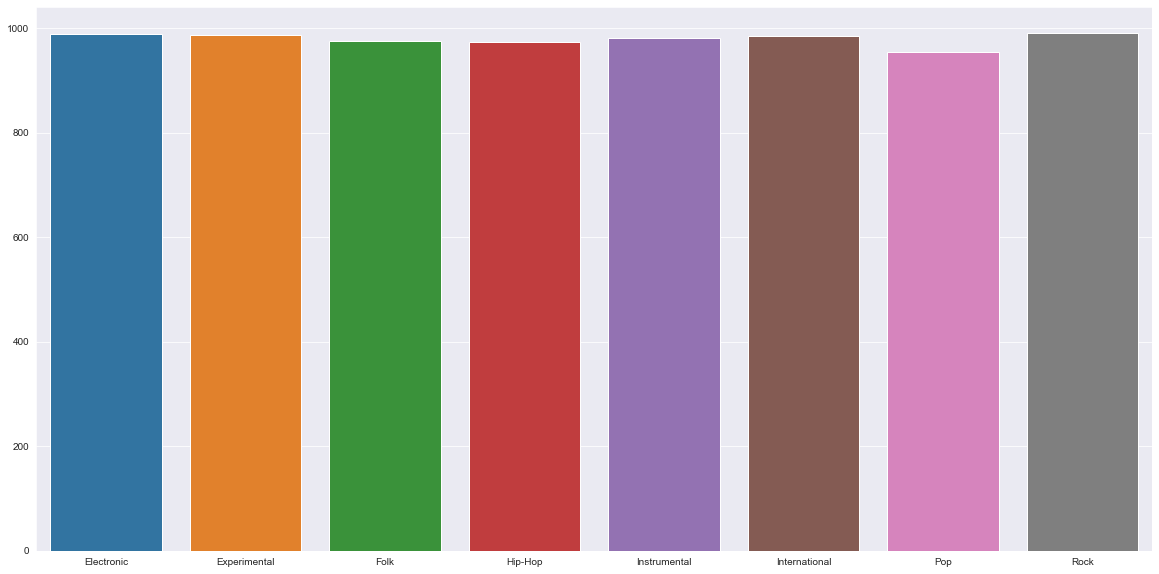

In [7]:
value_counts = track_genres.value_counts()
value_counts = value_counts[value_counts != 0]
print(value_counts)
#value_counts.plot.bar()
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=value_counts.index.remove_unused_categories(), y=value_counts.values, ax=ax)

In [8]:
# Assign a number to each genre
genres = {}
index = 0
for i in track_genres.unique():
    genres[i] = index
    index += 1
print(genres)

{'Hip-Hop': 0, 'Instrumental': 1, 'Rock': 2, 'Folk': 3, 'Electronic': 4, 'Pop': 5, 'Experimental': 6, 'International': 7}


In [9]:
Path("models").mkdir(parents=True, exist_ok=True)

Genera il training e testing set con split 80/20.

In [10]:
# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features_df, track_genres, train_size=0.8, random_state=42, stratify=track_genres)

# Split remaining dataset in test and validation
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_valid = lab_encoder.transform(y_valid)
y_test = lab_encoder.transform(y_test)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}, Validation set: {X_valid.shape}")

Training set: (6272, 518), Testing set: (785, 518), Validation set: (784, 518)


In [11]:
def evaluate_classifier(x_tr, x_te, y_tr, y_te, model):
    start = time.process_time()
    model.fit(x_tr, y_tr)
    estimated = time.process_time() - start
    prediction = model.predict(x_te)
    x = classification_report(y_te, prediction, output_dict=True)
    return x, estimated

### PCA
Si applica PCA per ridurre la dimensionalità delle feature.

In [78]:
pca = PCA(n_components = 'mle')
pca.fit(X_train)
pca_mle_train = pca.transform(X_train)
pca_mle_test = pca.transform(X_test)
pca_mle_val = pca.transform(X_valid)

pca = PCA(n_components = 10)
pca.fit(X_train)
pca_10_train = pca.transform(X_train)
pca_10_test = pca.transform(X_test)
pca_10_val = pca.transform(X_valid)

print(f"Senza PCA: {X_train.shape}, Applicando PCA MLE: {pca_mle_train.shape}, Applicando PCA 10: {pca_10_train.shape}")

Senza PCA: (6272, 518), Applicando PCA MLE: (6272, 517), Applicando PCA 10: (6272, 10)


Applicando PCA con l'opzione mle (da spiegare) si vede come il numero di feature diminuisca solamente di 1. Per questo si decide di non utilizzare la PCA mle.

### Model optimization
Si cercano gli iperparametri migliori rispetto all'F1

In [12]:
def optimize_model(model, x_train, y_train, parameters, to_scale=False):
    if to_scale:
        x_train = StandardScaler().fit_transform(x_train)

    gs = GridSearchCV(model, parameters, scoring='f1_micro', cv=2, return_train_score=True, n_jobs=-1, verbose=10)

    gs.fit(x_train, y_train)

    print("best parameters: ", gs.best_params_)
    print("score: ", gs.best_score_)
    return gs.best_estimator_

In [13]:
def print_results_classification_report(rep):
    print(f"Accuracy: {rep['accuracy']}, Precision: {rep['weighted avg']['precision']}, Recall: {rep['weighted avg']['recall']}, F1: {rep['weighted avg']['f1-score']}")

### SVM

In [88]:
# SVM model evaluation
param_evaluated = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}

svm_base_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_model = optimize_model(svm_base_model, X_train, y_train, param_evaluated)

svm_base_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
pca_10_svm_model = optimize_model(svm_base_model, pca_10_train, y_train, param_evaluated)

display(svm_model)
display(pca_10_svm_model)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
best parameters:  {'C': 10, 'gamma': 0.001}
score:  0.5409757653061225
Fitting 2 folds for each of 16 candidates, totalling 32 fits
best parameters:  {'C': 1, 'gamma': 0.01}
score:  0.4491390306122449


SVC(C=10, class_weight='balanced', gamma=0.001, probability=True)

SVC(C=1, class_weight='balanced', gamma=0.01, probability=True)

In [158]:
svm_rp, time_taken_svm_rp = evaluate_classifier(X_train, X_test, y_train, y_test, svm_model)

print("Without PCA")
print_results_classification_report(svm_rp)
print(f"Time taken: {time_taken_svm_rp}")


svm_10_rp, time_taken_10_svm_rp = evaluate_classifier(pca_10_train, pca_10_test, y_train, y_test, pca_10_svm_model)

print("With PCA 10")
print_results_classification_report(svm_10_rp)
print(f"Time taken: {time_taken_10_svm_rp}")

AttributeError: 'NoneType' object has no attribute 'fit'

In [109]:
svm_10_rp

{'0': {'precision': 0.4125,
  'recall': 0.35106382978723405,
  'f1-score': 0.3793103448275862,
  'support': 94},
 '1': {'precision': 0.46835443037974683,
  'recall': 0.3627450980392157,
  'f1-score': 0.4088397790055249,
  'support': 102},
 '2': {'precision': 0.46956521739130436,
  'recall': 0.5346534653465347,
  'f1-score': 0.5,
  'support': 101},
 '3': {'precision': 0.45528455284552843,
  'recall': 0.6086956521739131,
  'f1-score': 0.5209302325581395,
  'support': 92},
 '4': {'precision': 0.5575221238938053,
  'recall': 0.6057692307692307,
  'f1-score': 0.5806451612903226,
  'support': 104},
 '5': {'precision': 0.5625,
  'recall': 0.46875,
  'f1-score': 0.5113636363636364,
  'support': 96},
 '6': {'precision': 0.21621621621621623,
  'recall': 0.18823529411764706,
  'f1-score': 0.2012578616352201,
  'support': 85},
 '7': {'precision': 0.5619834710743802,
  'recall': 0.6126126126126126,
  'f1-score': 0.5862068965517242,
  'support': 111},
 'accuracy': 0.47388535031847134,
 'macro avg': 

In [150]:
# Save model
dump(svm_model, 'models/svm.joblib')
dump(pca_10_svm_model, 'models/svm_pca.joblib')

['models/svm_pca.joblib']

In [159]:
# Load model

svm_model = load('models/svm.joblib')
pca_10_svm_model = load('models/svm_pca.joblib')

prediction = svm_model.predict(X_test)

x = classification_report(y_test, prediction, output_dict=True)

print_results_classification_report(x)

AttributeError: 'NoneType' object has no attribute 'predict'

### K-nearest neighbors

In [104]:
# KNN model evaluation
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
param_evaluated = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_base_model = KNeighborsClassifier()
knn_model = optimize_model(knn_base_model, X_train, y_train, param_evaluated)
display(knn_model)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
best parameters:  {'leaf_size': 1, 'n_neighbors': 8, 'p': 1}
score:  0.4502551020408163


KNeighborsClassifier(leaf_size=1, n_neighbors=8, p=1)

In [111]:
knn_rp, time_knn = evaluate_classifier(X_train, X_test, y_train, y_test, knn_model)

print_results_classification_report(knn_rp)
print(f"Time elapsed: {time_knn}")

Accuracy: 0.4929936305732484, Precision: 0.5080127244538775, Recall: 0.4929936305732484, F1: 0.47737111532706045


In [155]:
# Save model
dump(knn_model, 'models/knn.joblib')

['models/knn.joblib']

In [156]:
# Load model
knn_model = load('models/knn.joblib')

In [157]:
print(type(knn_model))

<class 'NoneType'>


### Random Forest

In [119]:
# random forest model evaluation
n_estimators = list(range(90, 101))

param_evaluated = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': n_estimators}

"""param_evaluated = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}"""

rf_base_model = RandomForestClassifier()
rf_model = optimize_model(rf_base_model, X_train, y_train, param_evaluated)
display(rf_model)

Fitting 2 folds for each of 22 candidates, totalling 44 fits
best parameters:  {'criterion': 'gini', 'n_estimators': 93}
score:  0.5049426020408163


RandomForestClassifier(n_estimators=93)

In [120]:
rf_rp, time_rf = evaluate_classifier(X_train, X_test, y_train, y_test, rf_model)

print_results_classification_report(rf_rp)
print(f"Time elapsed: {time_rf}")

Accuracy: 0.5273885350318471, Precision: 0.516891066189402, Recall: 0.5273885350318471, F1: 0.5163819610563711
Time elapsed: 6.643411000000015


In [121]:
# Save model
dump(rf_model, 'models/rf.joblib')

['models/rf.joblib']

### Naive Bayes

In [123]:
# naive bayes model evaluation
param_evaluated = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

nb_base_model = GaussianNB()
nb_model = optimize_model(nb_base_model, X_train, y_train, param_evaluated)
display(nb_model)

Fitting 2 folds for each of 14 candidates, totalling 28 fits
best parameters:  {'var_smoothing': 0.01}
score:  0.3926977040816327


GaussianNB(var_smoothing=0.01)

In [124]:
nb_rp, time_nb = evaluate_classifier(X_train, X_test, y_train, y_test, nb_model)

print_results_classification_report(nb_rp)
print(f"Time elapsed: {time_nb}")

Accuracy: 0.41656050955414015, Precision: 0.4244684545164918, Recall: 0.41656050955414015, F1: 0.3836489789674781
Time elapsed: 0.026503999999931693


### Neural Network

In [14]:
y_train_categorical = tf.keras.utils.to_categorical(y_train)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid)
y_test_categorical = tf.keras.utils.to_categorical(y_test)

In [15]:
def model_neural_network(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(Dense(hp_units1, activation='relu', input_shape=(518,)))

    #hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    #model.add(layers.Dropout(hp_dropout1))

    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(Dense(hp_units2, activation='relu'))

    #hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
    #model.add(layers.Dropout(hp_dropout1))

    model.add(Dense(len(y_train_categorical[1]), activation='softmax'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_neural_network,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='models/neural_network',
                     project_name='mgrr')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train_categorical, epochs=50, validation_data=(X_valid, y_valid_categorical), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Units1: {best_hps.get('units1')}
Units2: {best_hps.get('units2')}
Learning Rate: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.5778061151504517

Best val_accuracy So Far: 0.5994898080825806
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit

Units1: 256
Units2: 256
Learning Rate: 0.001.



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               132864    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 200,712
Trainable params: 200,712
Non-trainable params: 0
_________________________________________________________________
None


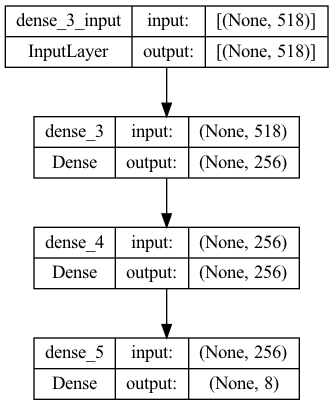

In [16]:
neural_model = tuner.hypermodel.build(best_hps)

print(neural_model.summary())
keras.utils.plot_model(neural_model, show_shapes=True)

In [17]:
history = neural_model.fit(X_train, y_train_categorical, epochs=50, validation_data=(X_valid, y_valid_categorical))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
 17/196 [=>............................] - ETA: 1s - loss: 1.8544 - accuracy: 0.3162

2022-06-28 15:07:45.323618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 2s 8ms/step - loss: 1.5170 - accuracy: 0.4622 - val_loss: 1.3123 - val_accuracy: 0.5561
Epoch 2/50
  1/196 [..............................] - ETA: 1s - loss: 1.0071 - accuracy: 0.7500

2022-06-28 15:07:46.857650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 1s 8ms/step - loss: 1.1160 - accuracy: 0.6095 - val_loss: 1.2650 - val_accuracy: 0.5599
Epoch 3/50
196/196 [==============================] - 1s 8ms/step - loss: 0.9026 - accuracy: 0.6832 - val_loss: 1.2385 - val_accuracy: 0.5791
Epoch 4/50
196/196 [==============================] - 1s 8ms/step - loss: 0.7002 - accuracy: 0.7583 - val_loss: 1.3944 - val_accuracy: 0.5778
Epoch 5/50
196/196 [==============================] - 1s 8ms/step - loss: 0.5398 - accuracy: 0.8163 - val_loss: 1.4783 - val_accuracy: 0.5561
Epoch 6/50
196/196 [==============================] - 1s 8ms/step - loss: 0.3914 - accuracy: 0.8717 - val_loss: 1.6265 - val_accuracy: 0.5804
Epoch 7/50
196/196 [==============================] - 1s 8ms/step - loss: 0.2525 - accuracy: 0.9289 - val_loss: 1.6490 - val_accuracy: 0.5791
Epoch 8/50
196/196 [==============================] - 1s 8ms/step - loss: 0.1680 - accuracy: 0.9576 - val_loss: 2.0091 - val_accuracy: 0.5561
Epoch 9/50
196/19

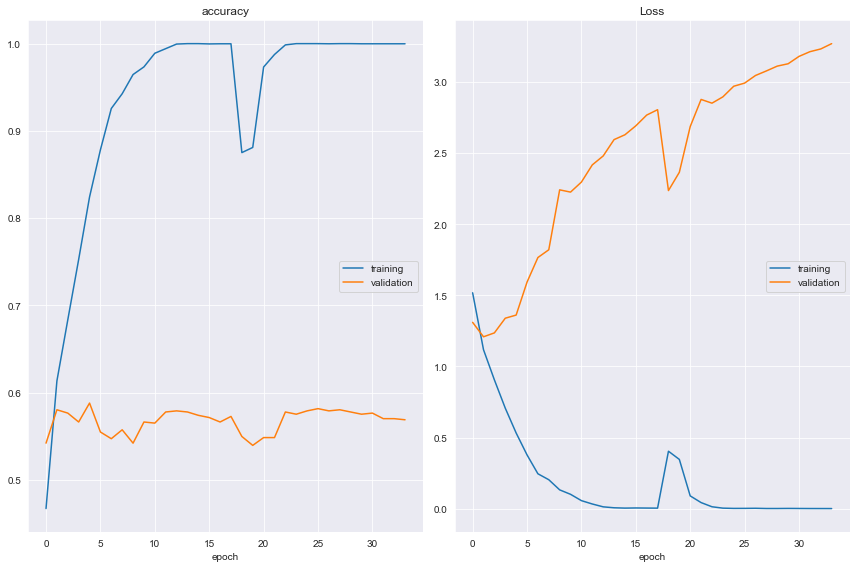

accuracy
	training         	 (min:    0.467, max:    1.000, cur:    1.000)
	validation       	 (min:    0.540, max:    0.588, cur:    0.569)
Loss
	training         	 (min:    0.001, max:    1.518, cur:    0.001)
	validation       	 (min:    1.209, max:    3.270, cur:    3.270)
196/196 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 3.2695 - val_accuracy: 0.5689


In [20]:
# Retrain the model
neural_model = tuner.hypermodel.build(best_hps)

start = time.process_time()
neural_model.fit(X_train, y_train_categorical, epochs=best_epoch, validation_data=(X_valid, y_valid_categorical), callbacks=[PlotLossesKeras()])
time_nn = time.process_time() - start

In [21]:
predictions = neural_model.predict(X_test)
nn_rp = classification_report(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=1), output_dict=True)

25/25 [==============================] - 0s 3ms/step


2022-06-28 15:12:20.547213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
print_results_classification_report(nn_rp)
print(f"Time elapsed: {time_nn}")

Accuracy: 0.5643312101910828, Precision: 0.5618326147456167, Recall: 0.5643312101910828, F1: 0.5622954540236035
Time elapsed: 85.80959100000001


In [23]:
neural_model.save('models/neural_network_saved')

INFO:tensorflow:Assets written to: models/neural_network_saved/assets


In [25]:
neural_model = keras.models.load_model('models/neural_network_saved')

neural_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               132864    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 200,712
Trainable params: 200,712
Non-trainable params: 0
_________________________________________________________________


### Dati CNN

In [6]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

track_ids = []
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]

  0%|          | 0/7847 [00:00<?, ?it/s]

# Modelli

## Spectrogram model
Questo modello è stato ottenuto dal paper [(Kostrzewa et al, 2021)](https://www.iccs-meeting.org/archive/iccs2021/papers/127420059.pdf), viene successivamente aggiunto un layer Dense e Dropout in più per poi iniziare la ricerca degli iperparametri migliori con keras tuner.

In [ ]:
def model2hp(hp):
    md = keras.Sequential()
    md.add(keras.Input(shape=(174, 484, 3)))
    hp_size = hp.Int('size', min_value=128, max_value=512, step=128)
    md.add(layers.Resizing(hp_size, hp_size))

    md.add(layers.Conv2D(64, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(64, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(128, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Conv2D(128, kernel_size=(5, 5), activation="relu"))
    md.add(layers.BatchNormalization())
    md.add(layers.MaxPooling2D(pool_size=(2, 2)))

    md.add(layers.Flatten())
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    md.add(layers.Dense(hp_units1, activation='relu'))

    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    md.add(layers.Dropout(hp_dropout1))
    md.add(layers.Dense(8, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    md.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return md

tuner = kt.Hyperband(model2hp,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir_2',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(validationgen, validation_data=validationgen, epochs=50, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Units: {best_hps.get('units')}
Dropout:{best_hps.get('dropout1')}
Learning Rate: {best_hps.get('learning_rate')}
Size: {best_hps.get('size')}
""")

model_spec = tuner.hypermodel.build(best_hps)
print(model_spec.summary())
keras.utils.plot_model(model_spec, show_shapes=True)

## Transfer Learning model
Questo modello fa utilizzo di VGG16.

In [ ]:
def create_model(input_shape, n_classes, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    md = Model(inputs=conv_base.input, outputs=output_layer)

    return md

model_vgg = create_model((174,484,3), 8)

print(model_vgg.summary())
keras.utils.plot_model(model_vgg, show_shapes=True)

# Risultati